<a href="https://colab.research.google.com/github/rugihub/deep_learning_2018-19/blob/master/%5Bseminar%5Dmlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>


<h2 style="text-align: center;"><b>Семинар 7. Многослойная сеть на PyTorch</b></h3>

В этом ноутбке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно - рассмотрим, как написать многослойную полносвязную сеть (Fully-Connected, FC), и сравним их качество на датасете картинок MNIST.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Многослойная нейронная сеть</b></h3>

Как можно понять из названия, многослойная нейросеть состоит из нескольких **слоёв**. Каждый слой состоит из **нейронов**. Ранее мы уже писали свой нейрон на NumPy, вот из таких нейронов и состоит ***MLP (Multi-Layer Perceptron)***. Ещё такую многослойную нейросеть, у которой каждый нейрон на предыдущем уровне соединён с нейроном на следующем уровне, называют ***Fully-Connected-сетью*** (или ***Dense-сетью***).  

Расмотрим их устройство более подробно:

* Вот так выглядит двухслойная нейросеть (первый слой - input layer - не считается, потому что это, по сути, не слой):

<img src="http://cs231n.github.io/assets/nn1/neural_net.jpeg" width=300, height=200>

* Так выглядит трёхслойная нейросеть:

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" width=400>

.. и так далее для большего случая слоёв.

**Обратите внимание:** связи есть у нейронов со слоя $L_{i-1}$  и нейронов $L_{i}$, но между нейронами в одном слое связей **нет**.

**Входной слой** -- это данные (матрица $(n, m)$).

Слои, которые не являются входными или выходными, называются **скрытыми слоями (hidden layers)**.

При решении ***задачи регрессии*** на **выходном слое** обычно один нейрон, который возвращает предсказанные числа (для каждого объекта по числу).  

В случае ***задачи классификации*** на **выходном слое** обычно один нейрон, если задача бинарной классификации, и $K$ нейронов, если задача $K$-класовой классификации.

#### Forward pass в MLP

Каждый слой многослойной нейросети - это матрица весов, строки которой - это нейроны (одна строка - один нейрон), а столбцы - веса каждого нейрона (то есть одна строка - это веса одного нейрона).

Допустим, мы решаем задачу $K$-классовой классификации (на последнем слое $K$ нейронов). Рассмотрим, как в таком случае выглядит `forward_pass` нейросети:

* Вход: $$X =
\left(
\begin{matrix} 
x_{11} & ... & x_{1M} \\
... & \ddots  & ...\\
x_{N1} & ... & x_{NM} 
\end{matrix}
\right)
$$

-- матрица $(N, M)$

* Структура сети - много слоёв, в слоях много нейронов. Первый слой (после входного) выглядит так:

$$ W^1 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_1} \\
... & \ddots  & ...\\
w_{M1} & ... & w_{ML_1} 
\end{matrix}
\right)
$$

-- матрица $(M, L_1)$

То есть это в точности $L_1$ нейронов, каждый имеет свои собственные веса, их $M$ штук.

Мы помним, что нейрон - это линейное преобразование и потом нелинейная функция активации от этого преобразования. Однако в многослойных нейростеях часто отделяют `Linear` часть и `Activation`, то есть слоем считаем набор весов нейронов, а следующий слой всегда функция активации (у всех нейронов из слоя она одна и та же, обычно фреймворки не позволяют задавать конкретному нейрону в слое отличную от других нейронов в этом слое функцию активации, однако это легко сделать, объявив слой из одного нейрона).

* Другие слои выглядит точно так же, как первый слой. Например, у второй слой будет такой:

$$ W^2 =
\left(
\begin{matrix} 
w_{11} & ... & w_{1L_2} \\
... & \ddots  & ...\\
w_{L_11} & ... & w_{L_1L_2} 
\end{matrix}
\right)
$$

-- матрица $(L_1, L_2)$

То есть это в точности $L_2$ нейронов, каждый имеет свои собственные веса, их $L_1$ штук.

* Выходной слой:  

Пусть в нейросети до выходного слоя идут $t$ слоёв. Тогда выходной слой имеет форму:

$$ W^{out} =
\left(
\begin{matrix} 
w_{11} & ... & w_{1K} \\
... & \ddots  & ...\\
w_{L_t1} & ... & w_{L_tK} 
\end{matrix}
\right)
$$

-- матрица $(L_t, K)$, где $L_t$ - количество нейронов в $t$-ом слое, а $K$ -- количество классов.

В итоге ***для `forward_pass` нам нужно просто последовтельно перемножить матрицы друг за другом, применяя после каждого умножения соответсвующую функцию активации***.

*Примечание*: можно думать об умножении на очередную матрицу весов как на переход в **новое признаковое пространство**. Действительно, когда подаём матрицу $X$ и умножаем на матрицу первого слоя, мы получаем матрицу размера $(N, L_1)$, то есть как будто $L_1$ "новых" признаков (построенных как линейная комбинация старых до применения функции активации, и уже как нелинейная комбинация после активации).

**Backward pass в MLP**

Обучается с помощью метода "Error Backpropagation" - ["Обратное распространение ошибки"](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%B1%D1%80%D0%B0%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%BE%D1%81%D1%82%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B8), принцип распространения очень похож на то, как мы обучали один нейрон - это градиентный спуск, но по "всей нейросети" сразу.  

Backpropagation работает корректно благодаря ***chain rule*** (=правилу взятия производной сложной функции):  

Если $f(x) = f(g(x))$, то:  

$$\frac{\partial{f}}{\partial{x}} = \frac{\partial{f}}{\partial{g}} \frac{\partial{g}}{\partial{x}}$$

Более подробно про backpropagation можно прочитать здесь (на английском):  https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch

## Датасет
Мы будем работать с датасетом "Игрушка дьявола". Генерация и отрисовка датасета:

In [0]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

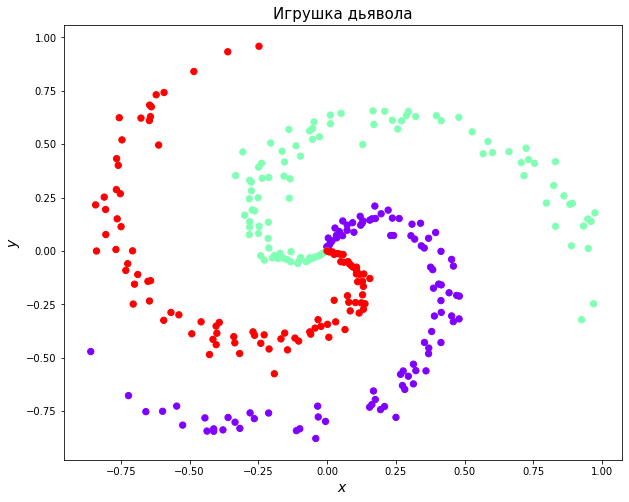

In [0]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Многослойная нейросеть на PyTorch</b></h3>

Ешё раз напомним про основные компоненты нейросети:

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количетсво итераций обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

## PyTorch для нейронных сетей

Основная абстракция для построения нейронной сети --- это torch.nn.Module. Module --- это те кирпичики, из которых мы будем складывать любую нейронную сеть. Как мы узнали на лекции, для определения модуля достаточно задать методы Forward и Backward. Базовый класс для nn.Module в PyTorch:



In [0]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.
    


### Модуль Sequential

Основной класс в PyTorch для работы с нейронными сетями --- это  Sequential.  Sequential --- это шаблон для самой простой последовательной нейронной сети. Методы Forward и Backward заданы соответственно: мы пробрасываем выходы и градиенты через все слои, из которых состоит Module. Посмотрим, как это работает.

Не будем медлить - бахнем 100 нейронов в двуслойную нейросеть. 

In [0]:
# N - размер батча (batch_size, нужно для метода оптимизации); 
# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
N, D_in, H, D_out = 64, 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Посмотрим, что у нас получилось. Пропустим мусорные данные через нашу модель методом forward.

In [0]:
print("Weight shapes:", [w.shape for w in two_layer_net.parameters()])

Weight shapes: [torch.Size([100, 2]), torch.Size([100]), torch.Size([3, 100]), torch.Size([3])]


In [0]:
# create dummy data with 3 samples and 784 features
x_batch = torch.tensor(X[:3], dtype=torch.float32)
y_batch = torch.tensor(y[:3], dtype=torch.float32)

# compute outputs given inputs, both are variables
y_predicted = two_layer_net(x_batch)[0]

y_predicted  # display what we've got

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.3104, 0.3040, 0.3855], grad_fn=<SelectBackward>)

## Код для генерации мини-батчей



In [0]:
from torch.autograd import Variable

In [0]:
def batch_gen(X, y, batch_size=128):
    idx = np.random.randint(X.shape[0], size=batch_size)
    X_batch = X[idx]
    y_batch = y[idx]
  
    return Variable(torch.FloatTensor(X_batch)), Variable(torch.LongTensor(y_batch))

In [0]:
batch_gen(X, y)[1].shape

torch.Size([128])

In [0]:
two_layer_net.forward(batch_gen(X,y)[0])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.3339, 0.3212, 0.3450],
        [0.3099, 0.3020, 0.3881],
        [0.3090, 0.3011, 0.3899],
        [0.2996, 0.3064, 0.3939],
        [0.3310, 0.3250, 0.3440],
        [0.3048, 0.3223, 0.3729],
        [0.3214, 0.3219, 0.3567],
        [0.3078, 0.2673, 0.4249],
        [0.3006, 0.2729, 0.4265],
        [0.3124, 0.3289, 0.3587],
        [0.2917, 0.3083, 0.4000],
        [0.3174, 0.2855, 0.3971],
        [0.3168, 0.3031, 0.3802],
        [0.3286, 0.3272, 0.3442],
        [0.2925, 0.2773, 0.4302],
        [0.2962, 0.2723, 0.4316],
        [0.2892, 0.3054, 0.4054],
        [0.3021, 0.2761, 0.4218],
        [0.3098, 0.3149, 0.3753],
        [0.3082, 0.3251, 0.3667],
        [0.2914, 0.3033, 0.4053],
        [0.3389, 0.3153, 0.3459],
        [0.3297, 0.3116, 0.3587],
        [0.3056, 0.2988, 0.3956],
        [0.3305, 0.2995, 0.3699],
        [0.3065, 0.3005, 0.3931],
        [0.3055, 0.2977, 0.3969],
        [0.2990, 0.3056, 0.3954],
        [0.3213, 0.3210, 0.3577],
        [0.314

Не забываем оборачивать данные (без этого градиенты не посчитать):

## Функция потерь и оптимизатор

In [0]:
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(two_layer_net.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## Обучение модели

In [0]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
for t in range(10000):
    x_batch, y_batch = batch_gen(X, y)
    
    # forward
    y_pred = two_layer_net(x_batch)

    # loss
    loss = loss_fn(y_pred, y_batch)
    print('{} {}'.format(t, loss.data))

    # ЗАНУЛЯЕМ!
    optimizer.zero_grad()

    # backward
    loss.backward()

    # ОБНОВЛЯЕМ! 
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 141.9066925048828
1 141.47357177734375
2 141.53387451171875
3 142.20553588867188
4 141.5504608154297
5 141.69210815429688
6 141.51699829101562
7 141.732666015625
8 141.59068298339844
9 141.21495056152344
10 142.2769775390625
11 140.82815551757812
12 140.68443298339844
13 141.3408660888672
14 141.34193420410156
15 140.53672790527344
16 141.9786834716797
17 141.20497131347656
18 140.6280059814453
19 140.6298370361328
20 141.0133514404297
21 140.46688842773438
22 140.3639678955078
23 140.3336181640625
24 141.25193786621094
25 141.31581115722656
26 140.39137268066406
27 141.11026000976562
28 141.0213623046875
29 140.25189208984375
30 140.4767608642578
31 140.09286499023438
32 140.0981903076172
33 140.88873291015625
34 140.56103515625
35 140.77081298828125
36 140.15855407714844
37 139.974853515625
38 139.81698608398438
39 139.8418426513672
40 139.86813354492188
41 139.791259765625
42 139.5592498779297
43 138.9732666015625
44 140.4160919189453
45 139.32403564453125
46 140.31332397460938
47

**Обратите внимание:** несмотря на то, что это задача 3-х классовой классификации и столбец $y$ нужно по-хорошему кодировать OneHotEncoding'ом, мы подали просто столбец из 0, 1 и 2 и всё отработало. Вывод - PyTorch сам делает OneHot в таком случае.

Проверим, насколько хороша наша сеть из 100 нейронов:

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


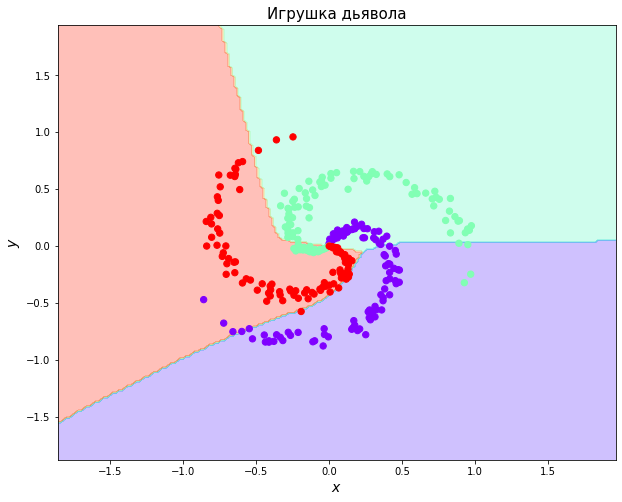

In [0]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = two_layer_net(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Качество не очень. Как же так, ведь мы использовали 100 нейронов? Разве их мало?

---

### Задача 2

Улучшите сеть (помните про вещи, которые можно менять (см. Компоненты нейросети)). Экспериментируйте, в этом **вся суть deep learning** (и в том, чтобы рано или поздно сетка научилась экспериментировать за Вас :)

In [0]:
# Ваш код здесь (можно (и нужно) создавать больше ячеек)

Несколько советов о том, как строить нейросети. Код выполнен на фреймворке Keras, но, кажется, он довольно интуитивно понятен.

* __Задача:__ Предсказать цену дома в $mil
* __Вход:__ 39 признаков этого дома

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([39]))
model.add(L.BatchNormalization())
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))

model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))

model.add(L.Dense(1))

model.compile(optimizer='sgd', loss='mean_squared_error')

NameError: ignored

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([39]))
model.add(L.BatchNormalization()) #<- можно просто нормализовать входы 
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros())) #<-инициализация нулями
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros())) #<-
model.add(L.Dense(1)) #<- три линейных слоя подряд ни к чему не приведут

model.compile(optimizer='sgd', loss='mean_squared_error') 

NameError: ignored

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([39]))
model.add(L.Dense(128, activation='sigmoid'))
model.add(L.BatchNormalization())
model.add(L.Dense(128, activation='sigmoid'))
model.add(L.Dense(1))

model.compile(optimizer='sgd', loss='mean_squared_error')

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))
model.add(L.Dense(10))
model.add(L.Activation('softmax'))
model.add(L.Dropout(0.1))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1)) # < хороший, годный дропаут
model.add(L.Dense(10))
model.add(L.Activation('softmax'))
model.add(L.Dropout(0.1))
# ^ не стоит dropout-ить вероятности на выходе, рискуете получить бесконечный лосс
model.compile(optimizer='rmsprop', loss='mean_squared_error')
# ^ обучать классификацию по квадратичной ошибке можно, но... это безбожно

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))
model.add(L.Dense(10))
model.add(L.Activation('softmax'))

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*

6). *Подробнее про backprop -- статья на Medium: https://medium.com/autonomous-agents/backpropagation-how-neural-networks-learn-complex-behaviors-9572ac161670*

7). *Статья из интернет по Backprop: http://page.mi.fu-berlin.de/rojas/neural/chapter/K7.pdf*